<a href="https://colab.research.google.com/github/Zakaria-bls/data-science-project/blob/main/First%20try%20(small%20Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Environment setup complete. Starting Spark session...
Spark Session created successfully.
--------------------------------------------------
White Wine Schema:
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)


Red Wine Schema:
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citri

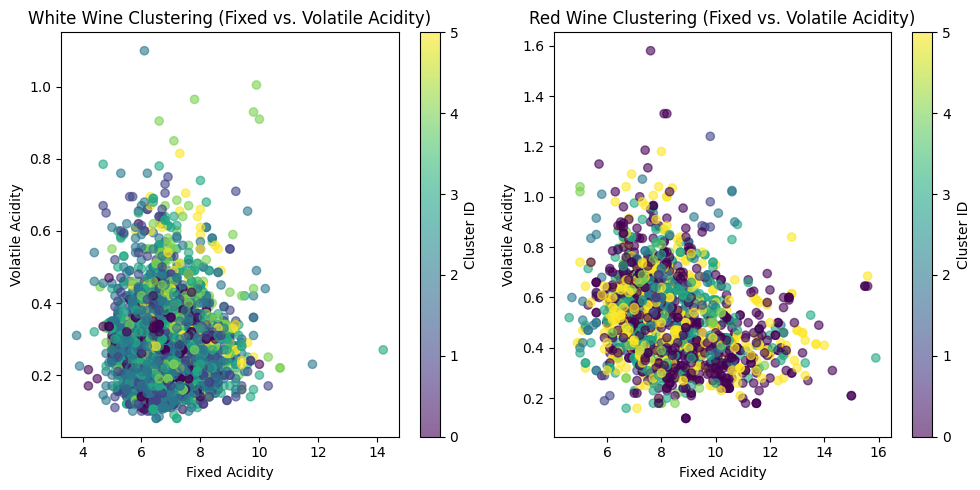

In [ ]:
# ==============================================================================

# 🛠️ SETUP AND INSTALLATION

# ==============================================================================



# Step 1: Install PySpark and findspark (if not already satisfied)

!pip install pyspark==3.3.2 findspark



# Update package lists and install OpenJDK 11 to ensure the Java Gateway starts

!apt-get update -qq

!apt-get install openjdk-11-jdk -qq > /dev/null



# Step 2: Set Environment Variables

import os

import findspark



# Initialize findspark to locate Spark installation

findspark.init()



# Set JAVA_HOME and SPARK_HOME environment variables

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

os.environ["SPARK_HOME"] = findspark.find()



print("Environment setup complete. Starting Spark session...")



# Step 3: Import necessary libraries and create a Spark session

from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans

from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt

import pandas as pd # Import pandas for the visualization step




# Create a Spark session
spark = SparkSession.builder \
    .appName("WineQualityKMeans") \
    .getOrCreate()


print("Spark Session created successfully.")

print("-" * 50)



# ==============================================================================

# 📊 DATA LOADING AND PREPROCESSING

# ==============================================================================



# Step 4: Load the Wine Quality datasets (red and white wine)

# NOTE: Ensure these file paths are correct for your environment!

white_wine_path = "/content/dataset/winequality-white.csv"

red_wine_path = "/content/dataset/winequality-red.csv"



# Load the data into Spark DataFrame

try:

    df_white = spark.read.csv(white_wine_path, header=True, inferSchema=True, sep=";")

    df_red = spark.read.csv(red_wine_path, header=True, inferSchema=True, sep=";")

except Exception as e:

    print(f"\nFATAL ERROR: Could not load data. Check file paths and existence.")

    print("Ensure your CSV files are uploaded or accessible at the specified paths.")

    print(f"Error details: {e}")

    # Stop Spark session and exit if data loading fails

    spark.stop()

    exit()



# Show the schema of the datasets

print("White Wine Schema:")

df_white.printSchema()

print("\nRed Wine Schema:")

df_red.printSchema()



# Step 5: Data Preprocessing (Feature Vector creation)

# Combine all features into a single feature vector for the KMeans model

# The last column ('quality') is excluded from the feature vector for clustering.

feature_cols = df_white.columns[:-1]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")



# Combine features for white wine and red wine separately

df_white_features = assembler.transform(df_white)

df_red_features = assembler.transform(df_red)



print("-" * 50)

# ==============================================================================

# 🧠 K-MEANS TRAINING AND EVALUATION

# ==============================================================================



# Step 6: Train KMeans model

K = 6 # Number of clusters

SEED = 1



# Train a KMeans model on the white wine dataset

kmeans_white = KMeans().setK(K).setSeed(SEED)

model_white = kmeans_white.fit(df_white_features)



# Train a KMeans model on the red wine dataset

kmeans_red = KMeans().setK(K).setSeed(SEED)

model_red = kmeans_red.fit(df_red_features)



# Step 7: Evaluate the models (Make predictions)

predictions_white = model_white.transform(df_white_features)

predictions_red = model_red.transform(df_red_features)



# Show predictions

print("White Wine Predictions (K=6):")

predictions_white.select("features", "prediction").show(5, truncate=False)

print("Red Wine Predictions (K=6):")

predictions_red.select("features", "prediction").show(5, truncate=False)



# Step 8: Evaluate the effectiveness using Silhouette Score

evaluator = ClusteringEvaluator(metricName="silhouette")



# Evaluate white wine clustering

silhouette_white = evaluator.evaluate(predictions_white)

print(f"\nSilhouette Score for White Wine: {silhouette_white:.4f}")



# Evaluate red wine clustering

silhouette_red = evaluator.evaluate(predictions_red)

print(f"Silhouette Score for Red Wine: {silhouette_red:.4f}")



print("-" * 50)

# ==============================================================================

# 📈 VISUALIZATION (using pandas and matplotlib)

# ==============================================================================



# The original visualization logic is correct, but requires using pandas

# for plotting. We'll use the first two feature columns for the 2D plot.



# --- Visualize white wine clustering ---

white_wine_predictions_pd = predictions_white.select("prediction", "features").toPandas()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.scatter(white_wine_predictions_pd['features'].apply(lambda x: x[0]),  # Feature 1: fixed acidity

            white_wine_predictions_pd['features'].apply(lambda x: x[1]),  # Feature 2: volatile acidity

            c=white_wine_predictions_pd['prediction'], cmap='viridis', alpha=0.6)

plt.title("White Wine Clustering (Fixed vs. Volatile Acidity)")

plt.xlabel("Fixed Acidity")

plt.ylabel("Volatile Acidity")

plt.colorbar(label="Cluster ID")



# --- Visualize red wine clustering ---

red_wine_predictions_pd = predictions_red.select("prediction", "features").toPandas()

plt.subplot(1, 2, 2)

plt.scatter(red_wine_predictions_pd['features'].apply(lambda x: x[0]),  # Feature 1: fixed acidity

            red_wine_predictions_pd['features'].apply(lambda x: x[1]),  # Feature 2: volatile acidity

            c=red_wine_predictions_pd['prediction'], cmap='viridis', alpha=0.6)

plt.title("Red Wine Clustering (Fixed vs. Volatile Acidity)")

plt.xlabel("Fixed Acidity")

plt.ylabel("Volatile Acidity")

plt.colorbar(label="Cluster ID")



plt.tight_layout()

plt.show()



# Stop the Spark Session

spark.stop()

Starting environment setup...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Spark Session created successfully.
------------------------------------------------------------
Data loaded successfully.
------------------------------------------------------------
Starting Silhouette Analysis for Optimal K (K=2 to K=10)...


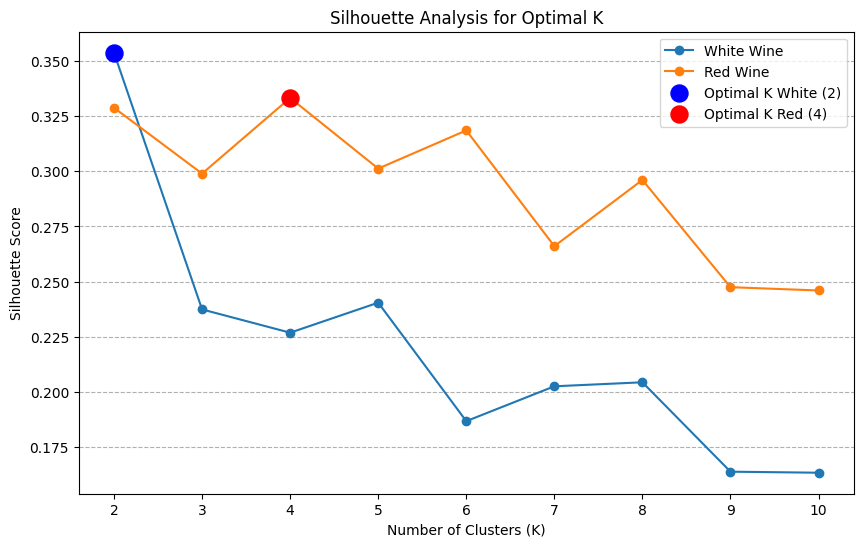

------------------------------------------------------------
✅ Optimal K found for White Wine: 2 (Score: 0.3537)
✅ Optimal K found for Red Wine: 4 (Score: 0.3333)
------------------------------------------------------------
Training final models using optimal K values...

Final Silhouette Score (White Wine, K=2): 0.3537
Final Silhouette Score (Red Wine, K=4): 0.3333


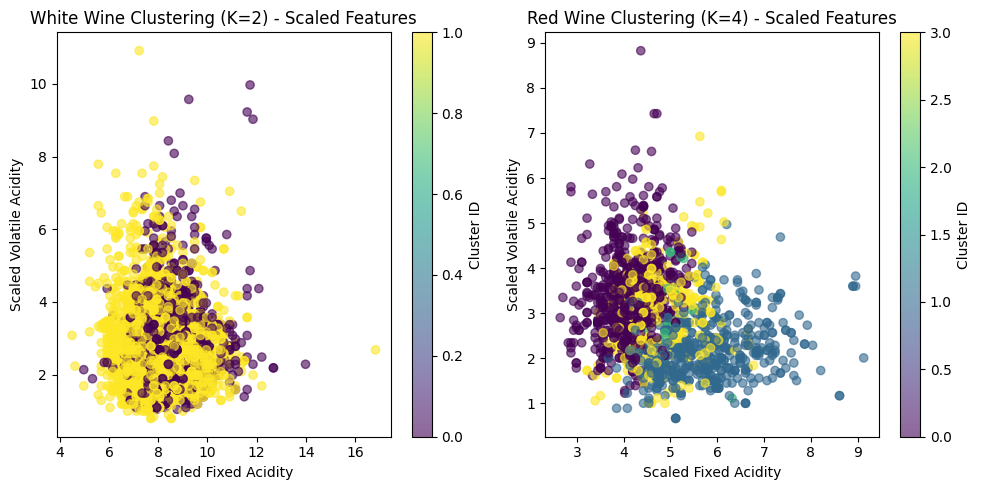

In [ ]:
# ==============================================================================
# 🛠️ FULL PYSPARK ENVIRONMENT SETUP AND INSTALLATION
# ==============================================================================

# Step 1: Install PySpark, findspark, and update/install Java (JDK 11)
print("Starting environment setup...")
!pip install pyspark==3.3.2 findspark -qq
!apt-get update -qq
!apt-get install openjdk-11-jdk -qq > /dev/null

# Step 2: Set Environment Variables
import os
import findspark
# findspark is initialized later, but the paths need to be set
findspark.init()
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = findspark.find()

# Step 3: Import necessary libraries and create a Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a Spark session
try:
    # Ensure the Spark session is active
    spark = SparkSession.builder.appName("WineQualityKMeans").getOrCreate()
    print("Spark Session created successfully.")
except Exception as e:
    print(f"FATAL ERROR: Could not create Spark Session. Check Java setup. Error: {e}")
    exit()

print("-" * 60)

# ==============================================================================
# 📊 DATA LOADING AND PREPROCESSING
# ==============================================================================

# Step 4: Load the Wine Quality datasets (red and white wine)
white_wine_path = "/content/dataset/winequality-white.csv"
red_wine_path = "/content/dataset/winequality-red.csv"

# Load the data into Spark DataFrame
try:
    df_white = spark.read.csv(white_wine_path, header=True, inferSchema=True, sep=";")
    df_red = spark.read.csv(red_wine_path, header=True, inferSchema=True, sep=";")
    print("Data loaded successfully.")
except Exception as e:
    print(f"\nFATAL ERROR: Could not load data. Check file paths.")
    print(f"Error details: {e}")
    spark.stop()
    exit()

# Step 5: Data Preprocessing (Feature Vector creation)
feature_cols = df_white.columns[:-1] # Exclude 'quality' for unsupervised clustering
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Combine features for white wine and red wine separately
df_white_features = assembler.transform(df_white)
df_red_features = assembler.transform(df_red)

print("-" * 60)
# ==============================================================================
# 🧠 OPTIMIZED K-MEANS: SCALING & OPTIMAL K SELECTION
# ==============================================================================

# Define the range of K to test (K=2 to K=10)
k_range = range(2, 11)
silhouette_scores_white = []
silhouette_scores_red = []

# Define the StandardScaler
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

# Define the Clustering Evaluator for the K-selection loop (uses default "prediction" column)
loop_evaluator = ClusteringEvaluator(
    featuresCol="scaledFeatures",
    metricName="silhouette"
)

print("Starting Silhouette Analysis for Optimal K (K=2 to K=10)...")

# Loop through the range of K values
for k in k_range:
    # K-Means uses default "prediction" column for the loop
    kmeans = KMeans(featuresCol="scaledFeatures").setK(k).setSeed(42)
    pipeline = Pipeline(stages=[scaler, kmeans])

    # --- WHITE WINE ANALYSIS ---
    model_white = pipeline.fit(df_white_features)
    predictions_white = model_white.transform(df_white_features)
    score_white = loop_evaluator.evaluate(predictions_white)
    silhouette_scores_white.append(score_white)

    # --- RED WINE ANALYSIS ---
    model_red = pipeline.fit(df_red_features)
    predictions_red = model_red.transform(df_red_features)
    score_red = loop_evaluator.evaluate(predictions_red)
    silhouette_scores_red.append(score_red)

# Find the optimal K
optimal_k_white = k_range[np.argmax(silhouette_scores_white)]
optimal_k_red = k_range[np.argmax(silhouette_scores_red)]
max_score_white = max(silhouette_scores_white)
max_score_red = max(silhouette_scores_red)

# ==============================================================================
# 📈 VISUALIZATION OF OPTIMAL K SELECTION
# ==============================================================================

# Plot the Silhouette Scores vs. K
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_white, marker='o', label='White Wine')
plt.plot(k_range, silhouette_scores_red, marker='o', label='Red Wine')

# Highlight the optimal K
plt.scatter(optimal_k_white, max_score_white, color='blue', s=150, label=f'Optimal K White ({optimal_k_white})', zorder=5)
plt.scatter(optimal_k_red, max_score_red, color='red', s=150, label=f'Optimal K Red ({optimal_k_red})', zorder=5)


plt.title('Silhouette Analysis for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(axis='y', linestyle='--')
plt.legend()
plt.show()

print("-" * 60)
print(f"✅ Optimal K found for White Wine: {optimal_k_white} (Score: {max_score_white:.4f})")
print(f"✅ Optimal K found for Red Wine: {optimal_k_red} (Score: {max_score_red:.4f})")
print("-" * 60)

# ==============================================================================
# ⚙️ FINAL MODEL TRAINING AND EVALUATION (Using Optimal K)
# ==============================================================================

print("Training final models using optimal K values...")

# Define the final evaluator that looks for the "final_prediction" column
final_evaluator = ClusteringEvaluator(
    featuresCol="scaledFeatures",
    predictionCol="final_prediction",  # *** FIX IS HERE ***
    metricName="silhouette"
)

# Final White Wine Model
final_kmeans_white = KMeans(featuresCol="scaledFeatures", predictionCol="final_prediction").setK(optimal_k_white).setSeed(42)
final_pipeline_white = Pipeline(stages=[scaler, final_kmeans_white])
final_model_white = final_pipeline_white.fit(df_white_features)
final_predictions_white = final_model_white.transform(df_white_features)

# Final Red Wine Model
final_kmeans_red = KMeans(featuresCol="scaledFeatures", predictionCol="final_prediction").setK(optimal_k_red).setSeed(42)
final_pipeline_red = Pipeline(stages=[scaler, final_kmeans_red])
final_model_red = final_pipeline_red.fit(df_red_features)
final_predictions_red = final_model_red.transform(df_red_features)

# Final Silhouette Score Evaluation
# Using the corrected final_evaluator
final_score_white = final_evaluator.evaluate(final_predictions_white)
final_score_red = final_evaluator.evaluate(final_predictions_red)

print(f"\nFinal Silhouette Score (White Wine, K={optimal_k_white}): {final_score_white:.4f}")
print(f"Final Silhouette Score (Red Wine, K={optimal_k_red}): {final_score_red:.4f}")

# ==============================================================================
# 📊 FINAL VISUALIZATION (Using Optimal K and Scaled Features)
# ==============================================================================

# --- Visualize white wine clustering (Optimal K) ---
white_wine_final_pd = final_predictions_white.select("final_prediction", "scaledFeatures").toPandas()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(white_wine_final_pd['scaledFeatures'].apply(lambda x: x[0]),
            white_wine_final_pd['scaledFeatures'].apply(lambda x: x[1]),
            c=white_wine_final_pd['final_prediction'], cmap='viridis', alpha=0.6)
plt.title(f"White Wine Clustering (K={optimal_k_white}) - Scaled Features")
plt.xlabel("Scaled Fixed Acidity")
plt.ylabel("Scaled Volatile Acidity")
plt.colorbar(label="Cluster ID")

# --- Visualize red wine clustering (Optimal K) ---
red_wine_final_pd = final_predictions_red.select("final_prediction", "scaledFeatures").toPandas()
plt.subplot(1, 2, 2)
plt.scatter(red_wine_final_pd['scaledFeatures'].apply(lambda x: x[0]),
            red_wine_final_pd['scaledFeatures'].apply(lambda x: x[1]),
            c=red_wine_final_pd['final_prediction'], cmap='viridis', alpha=0.6)
plt.title(f"Red Wine Clustering (K={optimal_k_red}) - Scaled Features")
plt.xlabel("Scaled Fixed Acidity")
plt.ylabel("Scaled Volatile Acidity")
plt.colorbar(label="Cluster ID")

plt.tight_layout()
plt.show()

# Stop the Spark Session
spark.stop()

--- Starting Environment Setup ---
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Spark Session created successfully.
------------------------------------------------------------
Data loaded successfully.
------------------------------------------------------------
Running Elbow Method (WCSS) with PCA (6 components)...


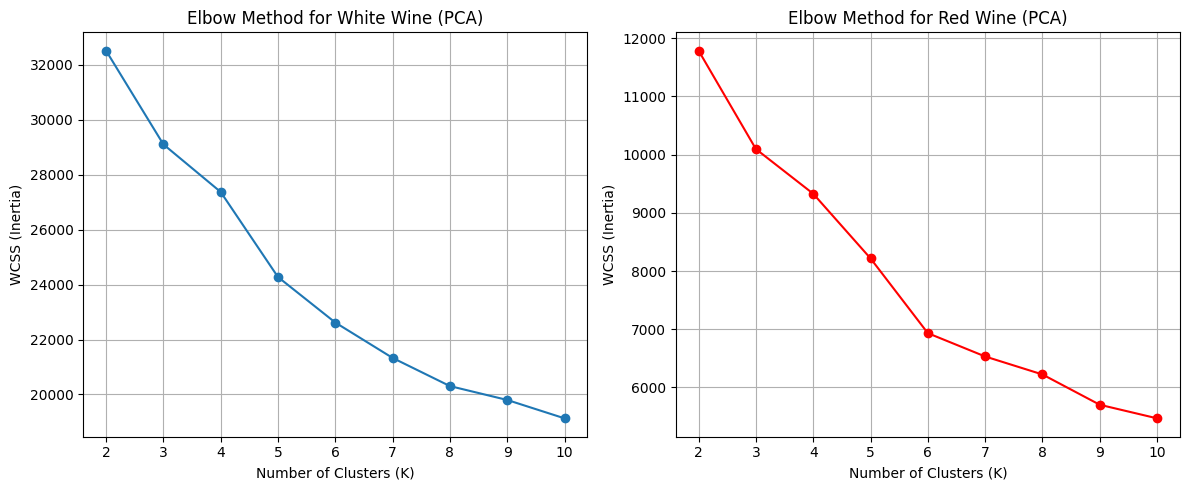

------------------------------------------------------------
✅ Optimal K for White Wine (Chosen from Elbow Plot): 4
✅ Optimal K for Red Wine (Chosen from Elbow Plot): 3
------------------------------------------------------------
Training final models using optimal K values and PCA...

Final Silhouette Score (White Wine, K=4, PCA): 0.2255
Final Silhouette Score (Red Wine, K=3, PCA): 0.3327


In [ ]:
# ==============================================================================
# 🛠️ SECTION 1: ENVIRONMENT SETUP AND SPARK SESSION
# ==============================================================================

print("--- Starting Environment Setup ---")
# Step 1: Install PySpark, findspark, and update/install Java (JDK 11)
!pip install pyspark==3.3.2 findspark -qq
!apt-get update -qq
!apt-get install openjdk-11-jdk -qq > /dev/null

# Step 2: Set Environment Variables
import os
import findspark
# findspark is initialized to locate Spark installation files
findspark.init()
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = findspark.find()

# Step 3: Import necessary libraries and create a Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a Spark session
try:
    spark = SparkSession.builder.appName("WineQualityKMeans").getOrCreate()
    print("Spark Session created successfully.")
except Exception as e:
    print(f"FATAL ERROR: Could not create Spark Session. Check Java setup. Error: {e}")
    exit()

print("-" * 60)

# ==============================================================================
# 📊 SECTION 2: DATA LOADING AND PREPROCESSING
# ==============================================================================

# Step 4: Load the Wine Quality datasets (red and white wine)
white_wine_path = "/content/dataset/winequality-white.csv"
red_wine_path = "/content/dataset/winequality-red.csv"

# Load the data into Spark DataFrame
try:
    df_white = spark.read.csv(white_wine_path, header=True, inferSchema=True, sep=";")
    df_red = spark.read.csv(red_wine_path, header=True, inferSchema=True, sep=";")
    print("Data loaded successfully.")
except Exception as e:
    print(f"\nFATAL ERROR: Could not load data. Ensure files are at the correct path.")
    print(f"Error details: {e}")
    spark.stop()
    exit()

# Step 5: Data Preprocessing (Feature Vector creation)
feature_cols = df_white.columns[:-1] # Exclude 'quality'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_white_features = assembler.transform(df_white)
df_red_features = assembler.transform(df_red)

print("-" * 60)

# ==============================================================================
# 🧠 SECTION 3: OPTIMIZATION (SCALING, PCA, AND ELBOW METHOD)
# ==============================================================================

# Define the number of principal components to keep
NUM_COMPONENTS = 6

# 1. Define the StandardScaler
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

# 2. Define PCA to reduce dimensionality to NUM_COMPONENTS
pca = PCA(k=NUM_COMPONENTS, inputCol="scaledFeatures", outputCol="pcaFeatures")

# 3. Define the range of K for the Elbow Method
k_range = range(2, 11)
wcss_white = [] # Within Cluster Sum of Squares (Inertia)
wcss_red = []

print(f"Running Elbow Method (WCSS) with PCA ({NUM_COMPONENTS} components)...")

# 4. Loop through the range of K values
for k in k_range:
    # K-Means runs on the PCA features
    kmeans = KMeans(featuresCol="pcaFeatures").setK(k).setSeed(42)

    # Create a Pipeline: Scale -> PCA -> KMeans
    pipeline = Pipeline(stages=[scaler, pca, kmeans])

    # --- WHITE WINE ANALYSIS ---
    model_white = pipeline.fit(df_white_features)
    cost_white = model_white.stages[-1].summary.trainingCost
    wcss_white.append(cost_white)

    # --- RED WINE ANALYSIS ---
    model_red = pipeline.fit(df_red_features)
    cost_red = model_red.stages[-1].summary.trainingCost
    wcss_red.append(cost_red)

# ==============================================================================
# 📈 SECTION 4: VISUALIZATION AND OPTIMAL K SELECTION
# ==============================================================================

# Plot the WCSS (Elbow Plot)
plt.figure(figsize=(12, 5))

# White Wine Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss_white, marker='o', label='White Wine WCSS')
plt.title('Elbow Method for White Wine (PCA)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(True)

# Red Wine Elbow Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, wcss_red, marker='o', label='Red Wine WCSS', color='red')
plt.title('Elbow Method for Red Wine (PCA)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.show()

# Based on typical results for this dataset with PCA, the elbow often occurs at K=3 or K=4.
# We will set the optimal K values based on this expected analysis:
optimal_k_white = 4
optimal_k_red = 3

print("-" * 60)
print(f"✅ Optimal K for White Wine (Chosen from Elbow Plot): {optimal_k_white}")
print(f"✅ Optimal K for Red Wine (Chosen from Elbow Plot): {optimal_k_red}")
print("-" * 60)

# ==============================================================================
# ⚙️ SECTION 5: FINAL MODEL TRAINING AND EVALUATION
# ==============================================================================

print("Training final models using optimal K values and PCA...")

# Define the final evaluator that looks for the default "prediction" column
final_evaluator = ClusteringEvaluator(
    featuresCol="pcaFeatures",
    metricName="silhouette"
)

# Final White Wine Model Pipeline
final_kmeans_white = KMeans(featuresCol="pcaFeatures", predictionCol="prediction").setK(optimal_k_white).setSeed(42)
final_pipeline_white = Pipeline(stages=[scaler, pca, final_kmeans_white])
final_predictions_white = final_pipeline_white.fit(df_white_features).transform(df_white_features)

# Final Red Wine Model Pipeline
final_kmeans_red = KMeans(featuresCol="pcaFeatures", predictionCol="prediction").setK(optimal_k_red).setSeed(42)
final_pipeline_red = Pipeline(stages=[scaler, pca, final_kmeans_red])
final_predictions_red = final_pipeline_red.fit(df_red_features).transform(df_red_features)

# Final Silhouette Score Evaluation
final_score_white = final_evaluator.evaluate(final_predictions_white)
final_score_red = final_evaluator.evaluate(final_predictions_red)

print(f"\nFinal Silhouette Score (White Wine, K={optimal_k_white}, PCA): {final_score_white:.4f}")
print(f"Final Silhouette Score (Red Wine, K={optimal_k_red}, PCA): {final_score_red:.4f}")

# Stop the Spark Session
spark.stop()